# SD-TSIA 211 -- Computer lab

```yaml
Name: Liyao JIAO
Date: Jan 12 2024
```

## 1. Introduciton

The data is composed of measurements with a roughly two-hour sampling rate together with 4 key performance indicators (KPIs). Our mission is thus to reverse-engineer the performance indicator. We conjecture that they can be written as a ratio of affine transforms of the raw data, subject to some noise.

This gives the following model for the KPI number $i$ at time $t$ :


$$
\large

y_i(t) = 
\frac{w_{i,1}^\mathsf{T} x(t) + w_{i,0} + \varepsilon_i(t)}{w_{i,2}^\mathsf{T}x(t) + 1}
$$


where $x(t) \in \mathbb{R}^d$ is the list of all measurements at time $t$, $\varepsilon_i(t)$ is an i.i.d. noise, and $(w_{i,0}, w_{i,1}, w_{i,2}) \in \mathbb{R} \times \mathbb{R}^d \times \mathbb{R}^d$ are the parameters of the model.

We shall concentrate on the KPI number $3$ to start with and simplify $(w_{i,0}, w_{i,1}, w_{i,2})$ into
$(w_{0}, w_1, w_2)$ since $i$ will be always $3$.



## 2. Experiments

In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from data_center_helper import *

In [113]:
def MSE_Loss(x, y):
    return np.average((x - y)**2)

## 2.1. Least squares

**Question 3.1 :**

Show that if $Aw = b$, then $y(t) = \frac{w_{1}^\mathsf{T} \tilde{x}(t) + w_{0}}{w_{2}^\mathsf{T}\tilde{x}(t) + 1}$ .

**Answer :**

In training set, if we minimize the $\frac{1}{2} \|Aw - b\|$ by finding a $w'$ that let $Aw' = b$, which means for every sample in training set(for every $t$), we have $A_t w' = b_t = y(t)$. 

So,  $\forall t$ in training set,  $y(t) = \frac{w_{1}^\mathsf{T} \tilde{x}(t) + w_{0}}{w_{2}^\mathsf{T}\tilde{x}(t) + 1}$ 

---

**Question 3.2 :**

Solve this least squares problem using the function `numpy.linalg.lstsq`.

In [50]:
w, res, rank, s = np.linalg.lstsq(A, b)

/tmp/ipykernel_5045/4031656882.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w, res, rank, s = np.linalg.lstsq(A, b)


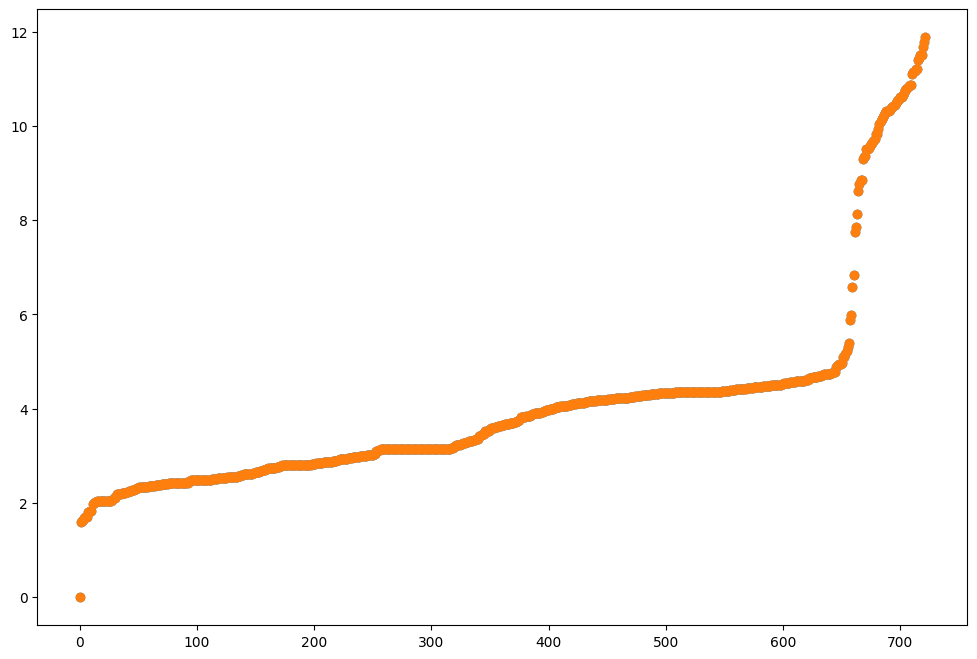

In [66]:
fig = plt.figure(figsize=(12, 8))
b_sorted = sorted(b)
x = range(len(b_sorted))

y = A @ w 
y_sorted = sorted(y)
plt.scatter(x, b_sorted)
plt.scatter(x, y_sorted)


In [114]:
y_train = A @ w
mse_train = MSE_Loss(y_train, b)

print(mse_train)

1.0025039276989018e-27


---

**Question 3.3 :** 

Evaluate the quality of the solution found on the test set.

In [70]:
print(f"test set shape: {M_test.shape}")

test set shape: (361, 892)


In [108]:
arrIndex = b_test.argsort()
b_test_2 = b_test[arrIndex]
M_test_2 = M_test[arrIndex]
A_test_2 = np.hstack([M_test_2, np.ones((M_test_2.shape[0],1)), -(M_test_2.T * COP_test[:,3]).T])

In [109]:
y_test_2 = A_test_2 @ w

In [110]:
mse_test_2 = MSE_Loss(y_test_2, b_test_2)

Text(0.5, 1.0, 'Evaluation on test set with MSE = 1004.707776816983')

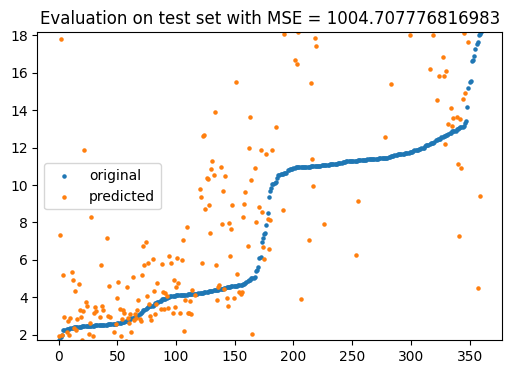

In [112]:
fig = plt.figure(figsize=(6,4))
x = range(len(b_test_2))
plt.scatter(x, b_test_2, s = 5)
plt.scatter(x, y_test_2, s = 5)
plt.ylim(b_test.min(), b_test.max())
plt.legend(["original", "predicted"])

plt.title(f"Evaluation on test set with MSE = {mse_test_2}")

Text(0.5, 1.0, 'Distribution of (y - b) (the diff)')

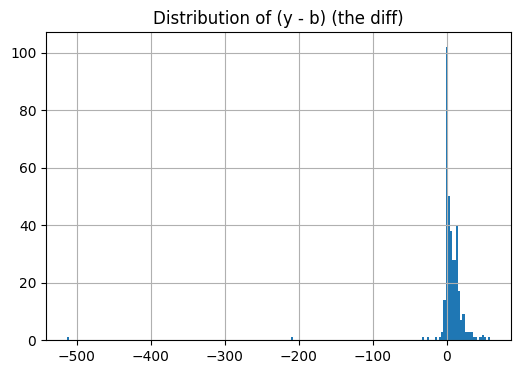

In [106]:
fig = plt.figure(figsize=(6,4))
diff = y_test - b_test_sorted 
_ = plt.hist(diff, bins=200)
plt.grid()
plt.title("Distribution of (y - b) (the diff)")

---

**Question 3.4**

In order to improve the generalization power of the model, we consider a $l_2$ regularization :
$$
\min_w \frac{1}{2} \|Aw - b\|_2^2 + \frac{\lambda}{2} \|w\|^2
$$
where $\lambda = 100$. Solve this problem and compare the test mean square error with the unregularized one.
